In [1]:
import os

import pandas as pd

from os.path import commonprefix
from pathlib import Path
from IPython.display import HTML

from Scripts.data_processing import obtain_data
from Scripts.fasta_processing import plain_to_fasta
from highlight import highlight_intron_in_seq
from fasta_processing import read_single_fasta, dict_align_to_fasta, read_fasta, dict_align_to_fasta_upd
from datasets import select_all_phylas, download_all_files_ncbi, check_transcript_count, update_data_for_species
from taxonomy_processing import create_taxonomy
from data_processing import analyze_exons, create_cassette, concat_cassette, dict_align_create, find_codon, \
    dict_align_info_analyze, dict_align_update_keys
from build_rna_structures import run_rnafold_with_highlight

In [2]:
column_names = ["tax_id", "org_name", "gene_id", "current_id", "status", "symbol", "aliases", "description",
                "other_designations", "map_location", "chromosome", "genomic_nucleotide_accession.version",
                "start_position_on_the_genomic_accession", "end_position_on_the_genomic_accession", "orientation",
                "exon_count", "to_delete_1", "to_delete_2"]

df = pd.read_csv("../all_nxf1_2.txt", sep="\t", skiprows=1, names=column_names, index_col=0)
df.drop(["to_delete_1", "to_delete_2"], axis=1, inplace=True)
df.head()

,org_name,gene_id,current_id,status,symbol,aliases,description,other_designations,map_location,chromosome,genomic_nucleotide_accession.version,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,orientation,exon_count
tax_id,,,,,,,,,,,,,,,
9606,Homo sapiens,10482,0,live,NXF1,"MEX67, TAP",nuclear RNA export factor 1,nuclear RNA export factor 1|mRNA export factor...,11q12.3,11,NC_000011.10,62792130.0,62805440.0,minus,22.0
10090,Mus musculus,53319,0,live,Nxf1,"Mex67, Mvb1, Tap",nuclear RNA export factor 1,nuclear RNA export factor 1|Mex 67 homolog|mRN...,19 5.5 cM,19,NC_000085.7,8734467.0,8748274.0,plus,20.0
10116,Rattus norvegicus,59087,0,live,Nxf1,"Mex67h, Tap",nuclear RNA export factor 1,nuclear RNA export factor 1|mRNA export factor...,1q43,1,NC_086019.1,215084563.0,215097756.0,plus,21.0
8407,Rana temporaria,120917577,0,live,NXF1,NaN,nuclear RNA export factor 1,nuclear RNA export factor 1,NaN,11,NC_053499.1,120752259.0,120809664.0,plus,22.0
8364,Xenopus tropicalis,734058,0,live,nxf1,"mex67, tap",nuclear RNA export factor 1,nuclear RNA export factor 1,NaN,4,NC_030680.2,36493131.0,36532401.0,minus,23.0


In [3]:
df_taxonomy = pd.read_csv("../all_phylas_taxonomy.tsv", sep="\t", names=["taxid", "taxonomy"], index_col=0,
                          dtype={"taxid": int, "taxonomy": str})

In [4]:
df_deuterostomia = df_taxonomy[df_taxonomy.taxonomy.str.contains("Deuterostomia")]

In [5]:
# df_deuterostomia.to_csv("../deuterostomia_taxonomy.tsv", sep="\t", header=False)
# create_taxonomy("../deuterostomia_taxonomy.tsv")

### Whippomorpha

In [6]:
df_whippomorpha = df_taxonomy[df_taxonomy.taxonomy.str.contains("Cetacea")]

df_mysticeti = df_whippomorpha[df_whippomorpha.taxonomy.str.contains("Mysticeti")]
df_odontoceti = df_whippomorpha[df_whippomorpha.taxonomy.str.contains("Odontoceti")]

whippomorpha_taxids = {
    "Mysticeti": df_mysticeti.index.tolist(),
    "Odontoceti": df_odontoceti.index.tolist(),
}

In [7]:
# df_whippomorpha.to_csv("../whippomorpha_taxonomy.tsv", sep="\t", index=True, header=False)

In [8]:
# create_taxonomy("../whippomorpha_taxonomy.tsv")

In [9]:
# download_all_files_ncbi(df, whippomorpha_taxids, phylas=list(whippomorpha_taxids.keys()))

In [10]:
# после изменения эта функция не должна ничего печатать
# whippomorpha_species_to_update = check_transcript_count(["Mysticeti", "Odontoceti"])

In [11]:
# update_data_for_species(whippomorpha_species_to_update)

In [12]:
def create_many_cassettes(phylum: str, data: dict) -> dict:
    introns = {}
    for org_name, (df, exons_i) in data.items():
        cassette = create_cassette(phylum, org_name, df, exons_i=exons_i)
        introns[org_name] = concat_cassette(cassette, "i")
    return introns

In [13]:
os.listdir("../Datasets/Mysticeti")

['balaenoptera_ricei_2',
 'balaenoptera_musculus_3',
 'balaenoptera_acutorostrata_4',
 'eschrichtius_robustus_0',
 'eubalaena_glacialis_1']

In [14]:
prefix = "../Datasets"
phylum = "Mysticeti"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

# Mysticeti
balaenoptera_ricei_2 = analyze_exons(
    f"{prefix}/{phylum}/balaenoptera_ricei_2/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

balaenoptera_musculus_3 = analyze_exons(
    f"{prefix}/{phylum}/balaenoptera_musculus_3/{postfix}/{nof}")  # 9 экзон ОГРОМНЫЙ 1977 нт || 116 43 | 14, 15

balaenoptera_acutorostrata_4 = analyze_exons(
    f"{prefix}/{phylum}/balaenoptera_acutorostrata_4/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

eschrichtius_robustus_0 = analyze_exons(
    f"{prefix}/{phylum}/eschrichtius_robustus_0/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

eubalaena_glacialis_1 = analyze_exons(
    f"{prefix}/{phylum}/eubalaena_glacialis_1/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

# у всех одинаково все, кроме
# balaenoptera_musculus_3 - объединение экзонов и интронов?

In [15]:
data_mysticeti = {
    "balaenoptera_ricei_2": (balaenoptera_ricei_2, [9, 10]),
    "balaenoptera_acutorostrata_4": (balaenoptera_acutorostrata_4, [9, 10]),
    "eschrichtius_robustus_0": (eschrichtius_robustus_0, [9, 10]),
    "eubalaena_glacialis_1": (eubalaena_glacialis_1, [9, 10]),
}

In [16]:
mysticeti_introns = create_many_cassettes("Mysticeti", data_mysticeti)

In [17]:
prefix = "../Datasets"
phylum = "Mysticeti"
postfix = "ncbi_dataset/data"
align_type = "cds_cassette"

org_names_mysticeti = os.listdir(f"{prefix}/Mysticeti")
org_names_mysticeti.remove("balaenoptera_musculus_3")

mysticeti_alignment_dict = dict_align_create(phylum, org_names_mysticeti, align_type)
mysticeti_alignment_dict_upd = {
    "_".join(key.split("_")[:-1]).capitalize(): value
    for key, value in mysticeti_alignment_dict.items()
}

os.makedirs(f"../Alignment/{phylum}", exist_ok=True)
dict_align_to_fasta(mysticeti_alignment_dict_upd, "../Alignment/Mysticeti/Mysticeti_cds_cassette.fa")
# dict_align_to_fasta(mysticeti_alignment_dict_upd, "../Alignment/Mysticeti/Mysticeti_cds_cassette.aln")

# выравнилось все, даже интрон

---

In [18]:
# удалил Odontoceti/phocoena_sinus_7, phocoena_sinus_6 кажется более полным

os.listdir("../Datasets/Odontoceti")

['delphinus_delphis_4',
 'pseudorca_crassidens_0',
 'delphinapterus_leucas_11',
 'monodon_monoceros_9',
 'kogia_breviceps_5',
 'lipotes_vexillifer_12',
 'globicephala_melas_8',
 'orcinus_orca_15',
 'lagenorhynchus_albirostris_2',
 'tursiops_truncatus_14',
 'physeter_macrocephalus_13',
 'phocoena_phocoena_1',
 'phocoena_sinus_6',
 'mesoplodon_densirostris_3',
 'neophocaena_asiaeorientalis_asiaeorientalis_10',
 'sagmatias_obliquidens_16']

---

In [19]:
prefix = "../Datasets"
phylum = "Odontoceti"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

# Odontoceti
delphinus_delphis_4 = analyze_exons(
    f"{prefix}/{phylum}/delphinus_delphis_4/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

pseudorca_crassidens_0 = analyze_exons(
    f"{prefix}/{phylum}/pseudorca_crassidens_0/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

delphinapterus_leucas_11 = analyze_exons(
    f"{prefix}/{phylum}/delphinapterus_leucas_11/{postfix}/{nof}")  # 110 37 | 10, 11 || 116 43 | 16, 17

monodon_monoceros_9 = analyze_exons(
    f"{prefix}/{phylum}/monodon_monoceros_9/{postfix}/{nof}")  # 110 37 | 10, 11 || 116 43 | 16, 17

kogia_breviceps_5 = analyze_exons(
    f"{prefix}/{phylum}/kogia_breviceps_5/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

lipotes_vexillifer_12 = analyze_exons(
    f"{prefix}/{phylum}/lipotes_vexillifer_12/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

globicephala_melas_8 = analyze_exons(
    f"{prefix}/{phylum}/globicephala_melas_8/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

orcinus_orca_15 = analyze_exons(
    f"{prefix}/{phylum}/orcinus_orca_15/{postfix}/{nof}")  # 110 37 | 10, 11 || 116 43 | 16, 17

lagenorhynchus_albirostris_2 = analyze_exons(
    f"{prefix}/{phylum}/lagenorhynchus_albirostris_2/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

tursiops_truncatus_14 = analyze_exons(
    f"{prefix}/{phylum}/tursiops_truncatus_14/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

physeter_macrocephalus_13 = analyze_exons(
    f"{prefix}/{phylum}/physeter_macrocephalus_13/{postfix}/{nof}")  # 110 37 | 8, 9 || 116 43 | 14, 15

phocoena_phocoena_1 = analyze_exons(
    f"{prefix}/{phylum}/phocoena_phocoena_1/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

phocoena_sinus_6 = analyze_exons(
    f"{prefix}/{phylum}/phocoena_sinus_6/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

mesoplodon_densirostris_3 = analyze_exons(
    f"{prefix}/{phylum}/mesoplodon_densirostris_3/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

neophocaena_asiaeorientalis_asiaeorientalis_10 = analyze_exons(
    f"{prefix}/{phylum}/neophocaena_asiaeorientalis_asiaeorientalis_10/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

sagmatias_obliquidens_16 = analyze_exons(
    f"{prefix}/{phylum}/sagmatias_obliquidens_16/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

In [20]:
data_odontoceti = {
    "delphinus_delphis_4": (delphinus_delphis_4, [9, 10]),
    "pseudorca_crassidens_0": (pseudorca_crassidens_0, [9, 10]),
    "delphinapterus_leucas_11": (delphinapterus_leucas_11, [10, 11]),
    "monodon_monoceros_9": (monodon_monoceros_9, [10, 11]),
    "kogia_breviceps_5": (kogia_breviceps_5, [9, 10]),
    "lipotes_vexillifer_12": (lipotes_vexillifer_12, [9, 10]),
    "globicephala_melas_8": (globicephala_melas_8, [9, 10]),
    "orcinus_orca_15": (orcinus_orca_15, [10, 11]),
    "lagenorhynchus_albirostris_2": (lagenorhynchus_albirostris_2, [9, 10]),
    "tursiops_truncatus_14": (tursiops_truncatus_14, [9, 10]),
    "physeter_macrocephalus_13": (physeter_macrocephalus_13, [8, 9]),
    "phocoena_phocoena_1": (phocoena_phocoena_1, [9, 10]),
    "phocoena_sinus_6": (phocoena_sinus_6, [9, 10]),
    "mesoplodon_densirostris_3": (mesoplodon_densirostris_3, [9, 10]),
    "neophocaena_asiaeorientalis_asiaeorientalis_10": (neophocaena_asiaeorientalis_asiaeorientalis_10, [9, 10]),
    "sagmatias_obliquidens_16": (sagmatias_obliquidens_16, [9, 10]),
}

In [21]:
odontoceti_introns = create_many_cassettes("Odontoceti", data_odontoceti)

In [22]:
prefix = "../Datasets"
phylum = "Odontoceti"
postfix = "ncbi_dataset/data"
align_type = "cds_cassette"

org_names = os.listdir(f"{prefix}/{phylum}")

odontoceti_alignment_dict = dict_align_create(phylum, org_names, align_type)
odontoceti_alignment_dict_upd = {
    "_".join(key.split("_")[:-1]).capitalize(): value
    for key, value in odontoceti_alignment_dict.items()
}

os.makedirs(f"../Alignment/{phylum}", exist_ok=True)
dict_align_to_fasta(odontoceti_alignment_dict_upd, "../Alignment/Odontoceti/Odontoceti_cds_cassette.fa")
# dict_align_to_fasta(odontoceti_alignment_dict_upd, "../Alignment/Odontoceti/Odontoceti_cds_cassette.aln")

---

In [23]:
prefix = "../Datasets"

org_names_mysticeti = os.listdir(f"{prefix}/Mysticeti")
org_names_mysticeti.remove("balaenoptera_musculus_3")

org_names_odontoceti = os.listdir(f"{prefix}/Odontoceti")

dict_align_info = {
    "Mysticeti": org_names_mysticeti,
    "Odontoceti": org_names_odontoceti,
}

In [24]:
# здесь везде должно быть True в столбце equal_to_cds

whippomorpha_df_cds, whippomorpha_dict_align_cds = dict_align_info_analyze(dict_align_info, "cds")
whippomorpha_df_cds

,phylum,org_name,stop_codon_pos,equal_to_cds,cassette_start,length_to_stop_codon,intron_length
0,Mysticeti,balaenoptera_ricei_2,1869,True,-1,1870,1831
1,Mysticeti,balaenoptera_acutorostrata_4,1869,True,-1,1870,1835
2,Mysticeti,eschrichtius_robustus_0,1869,True,-1,1870,1835
3,Mysticeti,eubalaena_glacialis_1,1860,True,-1,1861,1830
4,Odontoceti,delphinus_delphis_4,1860,True,-1,1861,1825
5,Odontoceti,pseudorca_crassidens_0,1860,True,-1,1861,1824
6,Odontoceti,delphinapterus_leucas_11,1860,True,-1,1861,1824
7,Odontoceti,monodon_monoceros_9,1860,True,-1,1861,1828
8,Odontoceti,kogia_breviceps_5,1860,True,-1,1861,1846
9,Odontoceti,lipotes_vexillifer_12,1860,True,-1,1861,1914


In [25]:
whippomorpha_df_cds_cassette, whippomorpha_dict_align_cds_cassette = dict_align_info_analyze(dict_align_info, "cds_cassette")
whippomorpha_df_cds_cassette

,phylum,org_name,stop_codon_pos,equal_to_cds,cassette_start,length_to_stop_codon,intron_length
0,Mysticeti,balaenoptera_ricei_2,1080,False,1028,52,1831
1,Mysticeti,balaenoptera_acutorostrata_4,1080,False,1028,52,1835
2,Mysticeti,eschrichtius_robustus_0,1080,False,1028,52,1835
3,Mysticeti,eubalaena_glacialis_1,1071,False,1019,52,1830
4,Odontoceti,delphinus_delphis_4,1071,False,1019,52,1825
5,Odontoceti,pseudorca_crassidens_0,1071,False,1019,52,1824
6,Odontoceti,delphinapterus_leucas_11,1071,False,1019,52,1824
7,Odontoceti,monodon_monoceros_9,1071,False,1019,52,1828
8,Odontoceti,kogia_breviceps_5,1071,False,1019,52,1846
9,Odontoceti,lipotes_vexillifer_12,1071,False,1019,52,1914


In [26]:
dict_align_to_fasta_upd(whippomorpha_dict_align_cds_cassette, "../Alignment/Whippomorpha_cds_cassette.fa")
# dict_align_to_fasta_upd(whippomorpha_dict_align_cds_cassette, "../Alignment/Whippomorpha_cds_cassette.aln")

---

In [27]:
prefix = "../Datasets"
phylum = "Mysticeti"
postfix = "ncbi_dataset/data"
align_type = "protein"

org_names = os.listdir(f"{prefix}/{phylum}")
org_names.remove("balaenoptera_musculus_3")

alignment_dict = dict_align_create(phylum, org_names, align_type)
alignment_dict_upd = {
    "_".join(key.split("_")[:-1]).capitalize(): value
    for key, value in alignment_dict.items()
}

dict_align_to_fasta(alignment_dict_upd, f"../Alignment/{phylum}/{phylum}_protein.fa")
# dict_align_to_fasta(alignment_dict_upd, f"../Alignment/{phylum}/{phylum}_protein.aln")

In [28]:
prefix = "../Datasets"
phylum = "Odontoceti"
postfix = "ncbi_dataset/data"
align_type = "protein"

org_names = os.listdir(f"{prefix}/{phylum}")

alignment_dict = dict_align_create(phylum, org_names, align_type)
alignment_dict_upd = {
    "_".join(key.split("_")[:-1]).capitalize(): value
    for key, value in alignment_dict.items()
}

dict_align_to_fasta(alignment_dict_upd, f"../Alignment/{phylum}/{phylum}_protein.fa")
# dict_align_to_fasta(alignment_dict_upd, f"../Alignment/{phylum}/{phylum}_protein.aln")

---

In [29]:
prefix = "../Datasets"
phylum = "Mysticeti"
postfix = "ncbi_dataset/data"

org_names = os.listdir(f"{prefix}/{phylum}")
org_names.remove("balaenoptera_musculus_3")

alignment_dict = {}
for org_name in org_names:
    data = obtain_data(phylum, org_name)
    formatted_org_name = org_name.rsplit("_", 1)[0].capitalize()
    alignment_dict[formatted_org_name] = data["protein_sliced"]

dict_align_to_fasta(alignment_dict, f"../Alignment/{phylum}/{phylum}_protein_sliced.fa")
# dict_align_to_fasta(alignment_dict, f"../Alignment/{phylum}/{phylum}_protein_sliced.aln")

In [30]:
prefix = "../Datasets"
phylum = "Odontoceti"
postfix = "ncbi_dataset/data"

org_names = os.listdir(f"{prefix}/{phylum}")

alignment_dict = {}
for org_name in org_names:
    data = obtain_data(phylum, org_name)
    formatted_org_name = org_name.rsplit("_", 1)[0].capitalize()
    alignment_dict[formatted_org_name] = data["protein_sliced"]

dict_align_to_fasta(alignment_dict, f"../Alignment/{phylum}/{phylum}_protein_sliced.fa")
# dict_align_to_fasta(alignment_dict, f"../Alignment/{phylum}/{phylum}_protein_sliced.aln")

---

#### RNAfold

In [31]:
prefix = "../Datasets"
phylum = "Mysticeti"
postfix = "ncbi_dataset/data"

org_names = os.listdir(f"{prefix}/{phylum}")
org_names.remove("balaenoptera_musculus_3")

alignment_dict = {}
for org_name in org_names:
    formatted_org_name = org_name.rsplit("_", 1)[0].capitalize()
    alignment_dict[formatted_org_name] = mysticeti_introns[org_name]

dict_align_to_fasta(alignment_dict, f"../Alignment/{phylum}/{phylum}_introns.fa")
# dict_align_to_fasta(alignment_dict, f"../Alignment/{phylum}/{phylum}_introns.aln")

In [32]:
# prefix = "../Alignment"
# phylum = "Mysticeti"
#
# run_rnafold_with_highlight(
#     Path(f"{prefix}/{phylum}/{phylum}_cds_cassette.fa"),
#     Path(f"{prefix}/{phylum}/{phylum}_introns.fa"),
#     Path(f"../rnafold_output/{phylum}_cds_cassette")
# )

In [33]:
prefix = "../Datasets"
phylum = "Odontoceti"
postfix = "ncbi_dataset/data"

org_names = os.listdir(f"{prefix}/{phylum}")

alignment_dict = {}
for org_name in org_names:
    formatted_org_name = org_name.rsplit("_", 1)[0].capitalize()
    alignment_dict[formatted_org_name] = odontoceti_introns[org_name]

dict_align_to_fasta(alignment_dict, f"../Alignment/{phylum}/{phylum}_introns.fa")
# dict_align_to_fasta(alignment_dict, f"../Alignment/{phylum}/{phylum}_introns.aln")

In [34]:
# prefix = "../Alignment"
# phylum = "Odontoceti"
#
# run_rnafold_with_highlight(
#     Path(f"{prefix}/{phylum}/{phylum}_cds_cassette.fa"),
#     Path(f"{prefix}/{phylum}/{phylum}_introns.fa"),
#     Path(f"../rnafold_output/{phylum}_cds_cassette")
# )

---

### Homo sapiens

In [35]:
df_homo = df_taxonomy[df_taxonomy.taxonomy.str.contains("Homo")]

In [37]:
homo_taxids = {
    "Homo": df_homo.index.tolist(),
}

df_homo_subset = df.loc[homo_taxids["Homo"]]
df_homo_subset_nxf1 = df_homo_subset[df_homo_subset["symbol"] == "NXF1"]

In [38]:
# download_all_files_ncbi(df_homo_subset_nxf1, homo_taxids, phylas=list(homo_taxids.keys()))

In [41]:
# после изменения эта функция не должна ничего печатать
homo_species_to_update = check_transcript_count(["Homo"])

In [40]:
update_data_for_species(homo_species_to_update)

In [42]:
prefix = "../Datasets"
phylum = "Homo"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

# Homo
homo_sapiens_0 = analyze_exons(
    f"{prefix}/{phylum}/homo_sapiens_0/{postfix}/{nof}")  # 110 37 | 9, 10 || 116 43 | 15, 16

In [43]:
data_homo = {
    "homo_sapiens_0": (homo_sapiens_0, [9, 10]),
}

In [44]:
homo_introns = create_many_cassettes("Homo", data_homo)

In [46]:
prefix = "../Datasets"
phylum = "Homo"
postfix = "ncbi_dataset/data"
align_type = "cds_cassette"

org_names_homo = os.listdir(f"{prefix}/{phylum}")

homo_alignment_dict = dict_align_create(phylum, org_names_homo, align_type)
homo_alignment_dict_upd = {
    "_".join(key.split("_")[:-1]).capitalize(): value
    for key, value in homo_alignment_dict.items()
}

os.makedirs(f"../Alignment/{phylum}", exist_ok=True)
dict_align_to_fasta(homo_alignment_dict_upd, "../Alignment/Homo/Homo_cds_cassette.fa")
# dict_align_to_fasta(homo_alignment_dict_upd, "../Alignment/Homo/Homo_cds_cassette.aln")

In [48]:
dict_align_info = {
    "Homo": org_names_homo,
}

In [49]:
homo_df_cds_cassette, homo_dict_align_cds_cassette = dict_align_info_analyze(dict_align_info, "cds")
homo_df_cds_cassette

,phylum,org_name,stop_codon_pos,equal_to_cds,cassette_start,length_to_stop_codon,intron_length
0,Homo,homo_sapiens_0,1815,True,-1,1816,1801


In [50]:
homo_df_cds_cassette, homo_dict_align_cds_cassette = dict_align_info_analyze(dict_align_info, "cds_cassette")
homo_df_cds_cassette

,phylum,org_name,stop_codon_pos,equal_to_cds,cassette_start,length_to_stop_codon,intron_length
0,Homo,homo_sapiens_0,1068,False,1016,52,1801


### Рыбы

#### Actinopterygii - Лучепёрые рыбы - 74 вида

In [5]:
df_Actinopterygii = df_taxonomy[df_taxonomy.taxonomy.str.contains("Actinopterygii")]

In [19]:
# df_actinopterygii.to_csv("../actinopterygii_taxonomy.tsv", sep="\t", index=True, header=False)
# create_taxonomy("../actinopterygii_taxonomy.tsv")

In [6]:
df_Otomorpha = df_Actinopterygii[df_Actinopterygii.taxonomy.str.contains("Otomorpha")]  # 16
df_Euteleosteomorpha = df_Actinopterygii[df_Actinopterygii.taxonomy.str.contains("Euteleosteomorpha")]  # 54
df_Osteoglossomorpha = df_Actinopterygii[df_Actinopterygii.taxonomy.str.contains("Osteoglossomorpha")]  # 2
df_Holostei = df_Actinopterygii[df_Actinopterygii.taxonomy.str.contains("Holostei")]  # 1
df_Cladistia = df_Actinopterygii[df_Actinopterygii.taxonomy.str.contains("Cladistia")]  # 1

In [7]:
Actinopterygii_taxids = {
    "Otomorpha": df_Otomorpha.index.tolist(),
    "Euteleosteomorpha": df_Euteleosteomorpha.index.tolist(),
    "Osteoglossomorpha": df_Osteoglossomorpha.index.tolist(),
    "Holostei": df_Holostei.index.tolist(),
    "Cladistia": df_Cladistia.index.tolist(),
}

In [34]:
# download_all_files_ncbi(df, Actinopterygii_taxids, phylas=list(Actinopterygii_taxids.keys()))

Gene, mRNA, protein for Otomorpha/colossoma_macropomum_0 downloaded successfully
Gene, mRNA, protein for Otomorpha/danio_rerio_1 downloaded successfully
Gene, mRNA, protein for Otomorpha/danio_rerio_2 downloaded successfully
Gene, mRNA, protein for Otomorpha/astyanax_mexicanus_3 downloaded successfully
Gene, mRNA, protein for Otomorpha/chanos_chanos_4 downloaded successfully
Gene, mRNA, protein for Otomorpha/denticeps_clupeoides_5 downloaded successfully
Gene, mRNA, protein for Otomorpha/tachysurus_fulvidraco_6 downloaded successfully
Gene, mRNA, protein for Otomorpha/electrophorus_electricus_7 downloaded successfully
Gene, mRNA, protein for Otomorpha/pangasianodon_hypophthalmus_8 downloaded successfully
Gene, mRNA, protein for Otomorpha/carassius_auratus_9 downloaded successfully
Gene, mRNA, protein for Otomorpha/pygocentrus_nattereri_10 downloaded successfully
Gene, mRNA, protein for Otomorpha/ictalurus_punctatus_11 downloaded successfully
Gene, mRNA, protein for Otomorpha/sinocycloc

In [8]:
# Actinopterygii_species_to_update = check_transcript_count(["Otomorpha", "Euteleosteomorpha", "Osteoglossomorpha", "Holostei", "Cladistia"])

Otomorpha/sinocyclocheilus_rhinocerous_12: 2 transcripts
Otomorpha/carassius_auratus_9: 2 transcripts
Otomorpha/sinocyclocheilus_grahami_14: 2 transcripts
Otomorpha/danio_rerio_2: 2 transcripts
Otomorpha/sinocyclocheilus_anshuiensis_13: 2 transcripts
Otomorpha/astyanax_mexicanus_3: 2 transcripts
Otomorpha/puntigrus_tetrazona_16: 2 transcripts
Otomorpha/clupea_harengus_15: 2 transcripts
Euteleosteomorpha/poecilia_mexicana_3: 2 transcripts
Euteleosteomorpha/xiphophorus_couchianus_28: 2 transcripts
Euteleosteomorpha/cottoperca_gobio_21: 3 transcripts
Euteleosteomorpha/cyprinodon_variegatus_41: 2 transcripts
Euteleosteomorpha/poecilia_reticulata_47: 2 transcripts
Euteleosteomorpha/takifugu_rubripes_55: 3 transcripts
Euteleosteomorpha/myripristis_murdjan_19: 6 transcripts
Euteleosteomorpha/betta_splendens_22: 3 transcripts
Euteleosteomorpha/etheostoma_spectabile_11: 8 transcripts
Euteleosteomorpha/larimichthys_crocea_46: 4 transcripts
Euteleosteomorpha/lates_calcarifer_4: 4 transcripts
Eute

In [9]:
# update_data_for_species(Actinopterygii_species_to_update)

In [10]:
# после апдейта ничего не должно выводиться в этой ячейке
Actinopterygii_species_to_update = check_transcript_count(["Otomorpha", "Euteleosteomorpha", "Osteoglossomorpha", "Holostei", "Cladistia"])

In [18]:
def create_many_cassettes(phylum: str, data: dict) -> dict:
    introns = {}
    for org_name, (df, exons_i) in data.items():
        cassette = create_cassette(phylum, org_name, df, exons_i=exons_i)
        introns[org_name] = concat_cassette(cassette, "i")
    return introns

#### Otomorpha

In [39]:
# создаем словарь data_Phylum

prefix = "../Datasets"
phylum = "Otomorpha"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

ref_exon_len = [37]
found_org_name_i_Otomorpha = {}  # CHANGE

for org_name_i in os.listdir(f"../Datasets/{phylum}"):
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    condition = set(ref_exon_len) & set(df_exons.length.tolist())
    if condition:
        found_org_name_i_Otomorpha[org_name_i] = condition  # CHANGE

data = {}

for org_name_i in found_org_name_i_Otomorpha:  # CHANGE
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    exon_37_idx = df_exons[df_exons["length"] == 37].index[0]
    exon_110_idx = exon_37_idx - 1
    data[f"{org_name_i}"] = (df_exons, [exon_110_idx, exon_37_idx])

introns = create_many_cassettes(phylum, data)

In [40]:
# создаем выравнивание cds_cassette для Phylum

align_type = "cds_cassette"

org_names_Otomorpha = list(found_org_name_i_Otomorpha.keys())  # CHANGE

alignment_dict = dict_align_create(phylum, org_names_Otomorpha, align_type)  # CHANGE
alignment_dict_upd = {
    "_".join(key.split("_")[:-1]).capitalize(): value
    for key, value in alignment_dict.items()
}

os.makedirs(f"../Alignment/{phylum}", exist_ok=True)
dict_align_to_fasta(alignment_dict_upd, f"../Alignment/{phylum}/{phylum}_cds_cassette.fa")
dict_align_to_fasta(alignment_dict_upd, f"../Alignment/{phylum}/{phylum}_cds_cassette.aln")

#### Euteleosteomorpha

In [41]:
# создаем словарь data_Phylum

prefix = "../Datasets"
phylum = "Euteleosteomorpha"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

ref_exon_len = [37]
found_org_name_i_Euteleosteomorpha = {}  # CHANGE

for org_name_i in os.listdir(f"../Datasets/{phylum}"):
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    condition = set(ref_exon_len) & set(df_exons.length.tolist())
    if condition:
        found_org_name_i_Euteleosteomorpha[org_name_i] = condition  # CHANGE

data = {}

for org_name_i in found_org_name_i_Euteleosteomorpha:  # CHANGE
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    exon_37_idx = df_exons[df_exons["length"] == 37].index[0]
    exon_110_idx = exon_37_idx - 1
    data[f"{org_name_i}"] = (df_exons, [exon_110_idx, exon_37_idx])

introns = create_many_cassettes(phylum, data)

In [42]:
# создаем выравнивание cds_cassette для Phylum

align_type = "cds_cassette"

org_names_Euteleosteomorpha = list(found_org_name_i_Euteleosteomorpha.keys())  # CHANGE

alignment_dict = dict_align_create(phylum, org_names_Euteleosteomorpha, align_type)  # CHANGE
alignment_dict_upd = {
    "_".join(key.split("_")[:-1]).capitalize(): value
    for key, value in alignment_dict.items()
}

os.makedirs(f"../Alignment/{phylum}", exist_ok=True)
dict_align_to_fasta(alignment_dict_upd, f"../Alignment/{phylum}/{phylum}_cds_cassette.fa")
dict_align_to_fasta(alignment_dict_upd, f"../Alignment/{phylum}/{phylum}_cds_cassette.aln")

#### Osteoglossomorpha

In [43]:
# создаем словарь data_Phylum

prefix = "../Datasets"
phylum = "Osteoglossomorpha"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

ref_exon_len = [37]
found_org_name_i_Osteoglossomorpha = {}  # CHANGE

for org_name_i in os.listdir(f"../Datasets/{phylum}"):
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    condition = set(ref_exon_len) & set(df_exons.length.tolist())
    if condition:
        found_org_name_i_Osteoglossomorpha[org_name_i] = condition  # CHANGE

In [44]:
found_org_name_i_Osteoglossomorpha  # CHANGE

{'paramormyrops_kingsleyae_0': {37}, 'scleropages_formosus_1': {37}}

In [45]:
data = {}

for org_name_i in found_org_name_i_Osteoglossomorpha:  # CHANGE
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    exon_37_idx = df_exons[df_exons["length"] == 37].index[0]
    exon_110_idx = exon_37_idx - 1
    data[f"{org_name_i}"] = (df_exons, [exon_110_idx, exon_37_idx])

introns = create_many_cassettes(phylum, data)

#### Holostei

In [46]:
# создаем словарь data_Phylum

prefix = "../Datasets"
phylum = "Holostei"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

ref_exon_len = [37]
found_org_name_i_Holostei = {}  # CHANGE

for org_name_i in os.listdir(f"../Datasets/{phylum}"):
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    condition = set(ref_exon_len) & set(df_exons.length.tolist())
    if condition:
        found_org_name_i_Holostei[org_name_i] = condition  # CHANGE

In [47]:
found_org_name_i_Holostei  # CHANGE

{}

#### Cladistia

In [50]:
# создаем словарь data_Phylum

prefix = "../Datasets"
phylum = "Cladistia"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

ref_exon_len = [37]
found_org_name_i_Cladistia = {}  # CHANGE

for org_name_i in os.listdir(f"../Datasets/{phylum}"):
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    condition = set(ref_exon_len) & set(df_exons.length.tolist())
    if condition:
        found_org_name_i_Cladistia[org_name_i] = condition

In [51]:
found_org_name_i_Cladistia  # CHANGE

{'erpetoichthys_calabaricus_0': {37}}

In [52]:
data = {}

for org_name_i in found_org_name_i_Cladistia:  # CHANGE
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    exon_37_idx = df_exons[df_exons["length"] == 37].index[0]
    exon_110_idx = exon_37_idx - 1
    data[f"{org_name_i}"] = (df_exons, [exon_110_idx, exon_37_idx])

introns = create_many_cassettes(phylum, data)

#### Анализ интрона у всех групп

In [53]:
prefix = "../Datasets"

org_names_Otomorpha = found_org_name_i_Otomorpha.keys()
org_names_Euteleosteomorpha = found_org_name_i_Euteleosteomorpha.keys()
org_names_Osteoglossomorpha = found_org_name_i_Osteoglossomorpha.keys()
org_names_Holostei = found_org_name_i_Holostei.keys()  # 0
org_names_Cladistia = found_org_name_i_Cladistia.keys()

In [54]:
dict_align_info = {
    "Otomorpha": org_names_Otomorpha,
    "Euteleosteomorpha": org_names_Euteleosteomorpha,
    "Osteoglossomorpha": org_names_Osteoglossomorpha,
    "Cladistia": org_names_Cladistia,
}

In [56]:
# здесь везде должно быть True в столбце equal_to_cds

Actinopterygii_df_cds, Actinopterygii_dict_align_cds = dict_align_info_analyze(dict_align_info, "cds")
Actinopterygii_df_cds.equal_to_cds.unique()

array([ True])

In [57]:
Actinopterygii_df_cds_cassette, Actinopterygii_dict_align_cds_cassette = dict_align_info_analyze(dict_align_info, "cds_cassette")
Actinopterygii_df_cds_cassette

,phylum,org_name,stop_codon_pos,equal_to_cds,cassette_start,length_to_stop_codon,intron_length
0,Otomorpha,ictalurus_punctatus_11,1104,False,1058,46,3166
1,Otomorpha,chanos_chanos_4,1071,False,1070,1,3568
2,Otomorpha,sinocyclocheilus_rhinocerous_12,1215,False,1061,154,3449
3,Otomorpha,carassius_auratus_9,1221,False,1073,148,3854
4,Otomorpha,denticeps_clupeoides_5,1041,False,1034,7,2629
...,...,...,...,...,...,...,...
68,Euteleosteomorpha,austrofundulus_limnaeus_42,1167,False,1145,22,2541
69,Euteleosteomorpha,seriola_lalandi_dorsalis_32,1185,False,1163,22,2481
70,Osteoglossomorpha,paramormyrops_kingsleyae_0,1254,False,1133,121,2929
71,Osteoglossomorpha,scleropages_formosus_1,1239,False,1127,112,3412


In [58]:
# dict_align_to_fasta_upd(Actinopterygii_dict_align_cds_cassette, "../Alignment/Actinopterygii_cds_cassette.fa")
# dict_align_to_fasta_upd(Actinopterygii_dict_align_cds_cassette, "../Alignment/Actinopterygii_cds_cassette.aln")

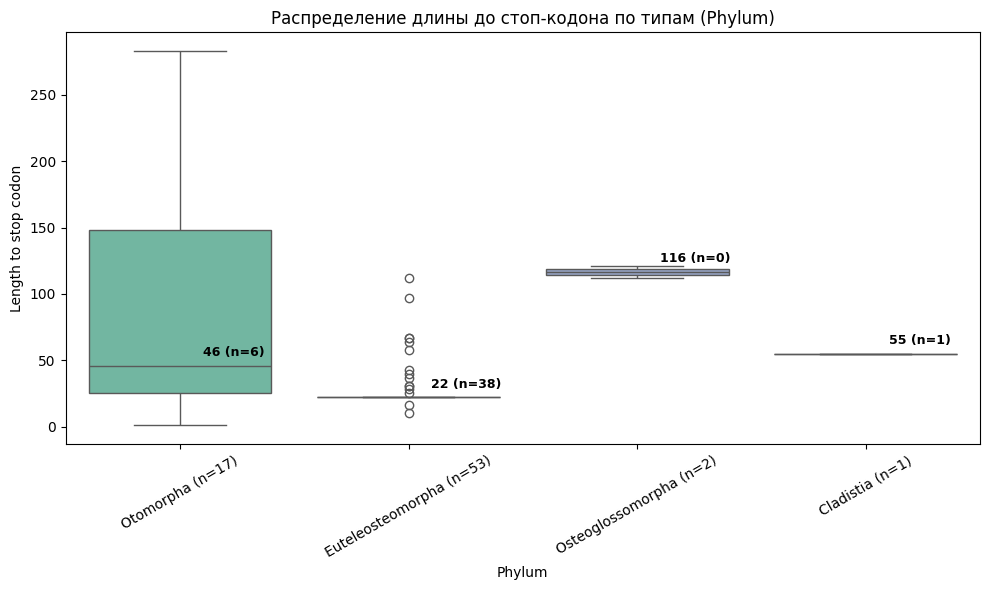

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Подсчёт количества значений по каждой филе
counts = Actinopterygii_df_cds_cassette['phylum'].value_counts()
ordered_phyla = Actinopterygii_df_cds_cassette['phylum'].unique()
group_labels = [f"{ph} (n={counts[ph]})" for ph in ordered_phyla]

# Создание графика
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=Actinopterygii_df_cds_cassette,
    x="phylum",
    y="length_to_stop_codon",
    hue="phylum",
    palette="Set2",
    dodge=False
)

# Удаление легенды, если она есть
if ax.legend_ is not None:
    ax.legend_.remove()

# Установка тиков и подписей оси X
ax.set_xticks(range(len(ordered_phyla)))
ax.set_xticklabels(group_labels, rotation=30)

# Расчёт и добавление подписей медиан
medians = (
    Actinopterygii_df_cds_cassette
    .groupby("phylum")["length_to_stop_codon"]
    .median()
)

for x, ph in enumerate(ordered_phyla):
    median_val = medians[ph]

    # Сколько раз медиана встречается в данных этой филы
    n_matches = (
        Actinopterygii_df_cds_cassette
        .query("phylum == @ph")["length_to_stop_codon"]
        .eq(median_val)
        .sum()
    )

    ax.text(
        x=x + 0.1,  # сдвиг подписи правее
        y=median_val + 5,
        s=f"{int(median_val)} (n={n_matches})",
        ha='left',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color='black'
    )

# Оформление
plt.title("Распределение длины до стоп-кодона по типам (Phylum)")
plt.xlabel("Phylum")
plt.ylabel("Length to stop codon")
plt.tight_layout()
plt.show()

In [73]:
dict_align_info = {
    "Otomorpha": org_names_Otomorpha,
    "Euteleosteomorpha": org_names_Euteleosteomorpha,
    "Osteoglossomorpha": org_names_Osteoglossomorpha,
    "Cladistia": org_names_Cladistia,
}

exon_1_lengths = []
for phylum, org_names in dict_align_info.items():
    for org_name in org_names:
        cassette = read_fasta(f"../Datasets/{phylum}/{org_name}/ncbi_dataset/data/cassette.fa")
        for header, seq in cassette.items():
            print(f"{phylum}-{org_name}: {len(seq)}")
            exon_1_lengths.append(len(seq))
            break

Otomorpha-ictalurus_punctatus_11: 110
Otomorpha-chanos_chanos_4: 110
Otomorpha-sinocyclocheilus_rhinocerous_12: 110
Otomorpha-carassius_auratus_9: 110
Otomorpha-denticeps_clupeoides_5: 110
Otomorpha-pygocentrus_nattereri_10: 110
Otomorpha-danio_rerio_1: 110
Otomorpha-pangasianodon_hypophthalmus_8: 110
Otomorpha-sinocyclocheilus_grahami_14: 110
Otomorpha-danio_rerio_2: 110
Otomorpha-electrophorus_electricus_7: 110
Otomorpha-tachysurus_fulvidraco_6: 110
Otomorpha-sinocyclocheilus_anshuiensis_13: 110
Otomorpha-astyanax_mexicanus_3: 110
Otomorpha-colossoma_macropomum_0: 110
Otomorpha-puntigrus_tetrazona_16: 110
Otomorpha-clupea_harengus_15: 110
Euteleosteomorpha-salarias_fasciatus_18: 110
Euteleosteomorpha-poecilia_mexicana_3: 110
Euteleosteomorpha-xiphophorus_couchianus_28: 110
Euteleosteomorpha-cottoperca_gobio_21: 110
Euteleosteomorpha-cyprinodon_variegatus_41: 110
Euteleosteomorpha-gouania_willdenowi_24: 110
Euteleosteomorpha-poecilia_reticulata_47: 110
Euteleosteomorpha-takifugu_rubri

In [77]:
len(exon_1_lengths)

73

#### Cephalochordata

In [78]:
df_Cephalochordata = df_taxonomy[df_taxonomy.taxonomy.str.contains("Cephalochordata")]

In [79]:
Cephalochordata_taxids = {
    "Cephalochordata": df_Cephalochordata.index.tolist(),
}

In [80]:
download_all_files_ncbi(df, Cephalochordata_taxids, phylas=list(Cephalochordata_taxids.keys()))

Gene, mRNA, protein for Cephalochordata/branchiostoma_floridae_0 downloaded successfully
Gene GenBank for Cephalochordata/branchiostoma_floridae_0 downloaded successfully
Exons for Cephalochordata/branchiostoma_floridae_0 created successfully



In [81]:
Cephalochordata_species_to_update = check_transcript_count(["Cephalochordata"])

In [9]:
# update_data_for_species(Cephalochordata_species_to_update)

In [140]:
# создаем словарь data_Phylum

prefix = "../Datasets"
phylum = "Cephalochordata"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

ref_exon_len = [37]
found_org_name_i_Cephalochordata = {}  # CHANGE

for org_name_i in os.listdir(f"../Datasets/{phylum}"):
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    condition = set(ref_exon_len) & set(df_exons.length.tolist())
    if condition:
        found_org_name_i_Cephalochordata[org_name_i] = condition  # CHANGE

found_org_name_i_Cephalochordata

{'branchiostoma_floridae_0': {37}}

In [88]:
data = {}

for org_name_i in found_org_name_i_Cephalochordata:  # CHANGE
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    exon_37_idx = df_exons[df_exons["length"] == 37].index[0]
    exon_110_idx = exon_37_idx - 1
    data[f"{org_name_i}"] = (df_exons, [exon_110_idx, exon_37_idx])

introns = create_many_cassettes(phylum, data)

#### Tunicata

In [102]:
df_Tunicata = df_taxonomy[df_taxonomy.taxonomy.str.contains("Tunicata")]

In [103]:
Tunicata_taxids = {
    "Tunicata": df_Tunicata.index.tolist(),
}

In [91]:
download_all_files_ncbi(df, Tunicata_taxids, phylas=list(Tunicata_taxids.keys()))

Gene, mRNA, protein for Tunicata/styela_clava_0 downloaded successfully
Gene GenBank for Tunicata/styela_clava_0 downloaded successfully
Exons for Tunicata/styela_clava_0 created successfully



In [104]:
Tunicata_species_to_update = check_transcript_count(["Tunicata"])

In [9]:
# update_data_for_species(Tunicata_species_to_update)

In [105]:
# создаем словарь data_Phylum

prefix = "../Datasets"
phylum = "Tunicata"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

ref_exon_len = [37]
found_org_name_i_Tunicata = {}  # CHANGE

for org_name_i in os.listdir(f"../Datasets/{phylum}"):
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    condition = set(ref_exon_len) & set(df_exons.length.tolist())
    if condition:
        found_org_name_i_Tunicata[org_name_i] = condition  # CHANGE

found_org_name_i_Tunicata

{'styela_clava_0': {37}}

In [106]:
data = {}

for org_name_i in found_org_name_i_Tunicata:  # CHANGE
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    exon_37_idx = df_exons[df_exons["length"] == 37].index[0]
    exon_110_idx = exon_37_idx - 1
    data[f"{org_name_i}"] = (df_exons, [exon_110_idx, exon_37_idx])

introns = create_many_cassettes(phylum, data)

#### Cyclostomata

In [107]:
df_Cyclostomata = df_taxonomy[df_taxonomy.taxonomy.str.contains("Cyclostomata")]

In [108]:
Cyclostomata_taxids = {
    "Cyclostomata": df_Cyclostomata.index.tolist(),
}

In [96]:
download_all_files_ncbi(df, Cyclostomata_taxids, phylas=list(Cyclostomata_taxids.keys()))

Gene, mRNA, protein for Cyclostomata/myxine_glutinosa_0 downloaded successfully
Gene, mRNA, protein for Cyclostomata/lethenteron_reissneri_1 downloaded successfully
Gene, mRNA, protein for Cyclostomata/petromyzon_marinus_2 downloaded successfully
Gene, mRNA, protein for Cyclostomata/petromyzon_marinus_3 downloaded successfully
Gene GenBank for Cyclostomata/myxine_glutinosa_0 downloaded successfully
Gene GenBank for Cyclostomata/lethenteron_reissneri_1 downloaded successfully
Gene GenBank for Cyclostomata/petromyzon_marinus_2 downloaded successfully
Gene GenBank for Cyclostomata/petromyzon_marinus_3 downloaded successfully
Exons for Cyclostomata/myxine_glutinosa_0 created successfully
Exons for Cyclostomata/lethenteron_reissneri_1 created successfully
Exons for Cyclostomata/petromyzon_marinus_2 created successfully
Exons for Cyclostomata/petromyzon_marinus_3 created successfully



In [109]:
Cyclostomata_species_to_update = check_transcript_count(["Cyclostomata"])

In [99]:
update_data_for_species(Cyclostomata_species_to_update)

In [110]:
# создаем словарь data_Phylum

prefix = "../Datasets"
phylum = "Cyclostomata"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

ref_exon_len = [37]
found_org_name_i_Cyclostomata = {}  # CHANGE

for org_name_i in os.listdir(f"../Datasets/{phylum}"):
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    condition = set(ref_exon_len) & set(df_exons.length.tolist())
    if condition:
        found_org_name_i_Cyclostomata[org_name_i] = condition  # CHANGE

found_org_name_i_Cyclostomata

{'petromyzon_marinus_2': {37},
 'lethenteron_reissneri_1': {37},
 'myxine_glutinosa_0': {37}}

In [111]:
data = {}

for org_name_i in found_org_name_i_Cyclostomata:  # CHANGE
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    exon_37_idx = df_exons[df_exons["length"] == 37].index[0]
    exon_110_idx = exon_37_idx - 1
    data[f"{org_name_i}"] = (df_exons, [exon_110_idx, exon_37_idx])

introns = create_many_cassettes(phylum, data)

#### Chondrichthyes

In [116]:
df_Chondrichthyes = df_taxonomy[df_taxonomy.taxonomy.str.contains("Chondrichthyes")]

In [117]:
Chondrichthyes_taxids = {
    "Chondrichthyes": df_Chondrichthyes.index.tolist(),
}

In [119]:
download_all_files_ncbi(df, Chondrichthyes_taxids, phylas=list(Chondrichthyes_taxids.keys()))

Gene, mRNA, protein for Chondrichthyes/amblyraja_radiata_0 downloaded successfully
Gene, mRNA, protein for Chondrichthyes/rhincodon_typus_1 downloaded successfully
Gene, mRNA, protein for Chondrichthyes/callorhinchus_milii_2 downloaded successfully
Gene GenBank for Chondrichthyes/amblyraja_radiata_0 downloaded successfully
Gene GenBank for Chondrichthyes/rhincodon_typus_1 downloaded successfully
Exons for Chondrichthyes/amblyraja_radiata_0 created successfully
Exons for Chondrichthyes/rhincodon_typus_1 created successfully



In [ ]:
# callorhinchus_milii_2 удалил, потому что там ничего не скачалось

In [122]:
Chondrichthyes_species_to_update = check_transcript_count(["Chondrichthyes"])

In [121]:
update_data_for_species(Chondrichthyes_species_to_update)

In [123]:
# создаем словарь data_Phylum

prefix = "../Datasets"
phylum = "Chondrichthyes"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

ref_exon_len = [37]
found_org_name_i_Chondrichthyes = {}  # CHANGE

for org_name_i in os.listdir(f"../Datasets/{phylum}"):
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    condition = set(ref_exon_len) & set(df_exons.length.tolist())
    if condition:
        found_org_name_i_Chondrichthyes[org_name_i] = condition  # CHANGE

found_org_name_i_Chondrichthyes

{'rhincodon_typus_1': {37}, 'amblyraja_radiata_0': {37}}

In [124]:
data = {}

for org_name_i in found_org_name_i_Chondrichthyes:  # CHANGE
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    exon_37_idx = df_exons[df_exons["length"] == 37].index[0]
    exon_110_idx = exon_37_idx - 1
    data[f"{org_name_i}"] = (df_exons, [exon_110_idx, exon_37_idx])

introns = create_many_cassettes(phylum, data)

#### Coelacanthimorpha

In [125]:
df_Coelacanthimorpha = df_taxonomy[df_taxonomy.taxonomy.str.contains("Coelacanthimorpha")]

In [126]:
Coelacanthimorpha_taxids = {
    "Coelacanthimorpha": df_Coelacanthimorpha.index.tolist(),
}

In [127]:
download_all_files_ncbi(df, Coelacanthimorpha_taxids, phylas=list(Coelacanthimorpha_taxids.keys()))

Gene, mRNA, protein for Coelacanthimorpha/latimeria_chalumnae_0 downloaded successfully
Gene GenBank for Coelacanthimorpha/latimeria_chalumnae_0 downloaded successfully
Exons for Coelacanthimorpha/latimeria_chalumnae_0 created successfully



In [128]:
Coelacanthimorpha_species_to_update = check_transcript_count(["Coelacanthimorpha"])

In [121]:
# update_data_for_species(Coelacanthimorpha_species_to_update)

In [129]:
# создаем словарь data_Phylum

prefix = "../Datasets"
phylum = "Coelacanthimorpha"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

ref_exon_len = [37]
found_org_name_i_Coelacanthimorpha = {}  # CHANGE

for org_name_i in os.listdir(f"../Datasets/{phylum}"):
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    condition = set(ref_exon_len) & set(df_exons.length.tolist())
    if condition:
        found_org_name_i_Coelacanthimorpha[org_name_i] = condition  # CHANGE

found_org_name_i_Coelacanthimorpha

{'latimeria_chalumnae_0': {37}}

In [130]:
data = {}

for org_name_i in found_org_name_i_Coelacanthimorpha:  # CHANGE
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    exon_37_idx = df_exons[df_exons["length"] == 37].index[0]
    exon_110_idx = exon_37_idx - 1
    data[f"{org_name_i}"] = (df_exons, [exon_110_idx, exon_37_idx])

introns = create_many_cassettes(phylum, data)

#### Dipnomorpha

In [131]:
df_Dipnomorpha = df_taxonomy[df_taxonomy.taxonomy.str.contains("Dipnomorpha")]

In [132]:
Dipnomorpha_taxids = {
    "Dipnomorpha": df_Dipnomorpha.index.tolist(),
}

In [133]:
download_all_files_ncbi(df, Dipnomorpha_taxids, phylas=list(Dipnomorpha_taxids.keys()))

Gene, mRNA, protein for Dipnomorpha/protopterus_annectens_0 downloaded successfully
Gene, mRNA, protein for Dipnomorpha/protopterus_annectens_1 downloaded successfully
Gene GenBank for Dipnomorpha/protopterus_annectens_0 downloaded successfully
Gene GenBank for Dipnomorpha/protopterus_annectens_1 downloaded successfully
Exons for Dipnomorpha/protopterus_annectens_0 created successfully
Exons for Dipnomorpha/protopterus_annectens_1 created successfully



In [134]:
Dipnomorpha_species_to_update = check_transcript_count(["Dipnomorpha"])

In [121]:
# update_data_for_species(Dipnomorpha_species_to_update)

In [135]:
# создаем словарь data_Phylum

prefix = "../Datasets"
phylum = "Dipnomorpha"
postfix = "ncbi_dataset/data"
nof = "exons.fa"

ref_exon_len = [37]
found_org_name_i_Dipnomorpha = {}  # CHANGE

for org_name_i in os.listdir(f"../Datasets/{phylum}"):
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    condition = set(ref_exon_len) & set(df_exons.length.tolist())
    if condition:
        found_org_name_i_Dipnomorpha[org_name_i] = condition  # CHANGE

found_org_name_i_Dipnomorpha

{'protopterus_annectens_0': {37}}

In [136]:
data = {}

for org_name_i in found_org_name_i_Dipnomorpha:  # CHANGE
    df_exons = analyze_exons(f"{prefix}/{phylum}/{org_name_i}/{postfix}/{nof}")
    exon_37_idx = df_exons[df_exons["length"] == 37].index[0]
    exon_110_idx = exon_37_idx - 1
    data[f"{org_name_i}"] = (df_exons, [exon_110_idx, exon_37_idx])

introns = create_many_cassettes(phylum, data)

#### Анализ интронов у отдельных микрогрупп

In [141]:
prefix = "../Datasets"

org_names_Cephalochordata = found_org_name_i_Cephalochordata.keys()
org_names_Tunicata = found_org_name_i_Tunicata.keys()
org_names_Cyclostomata = found_org_name_i_Cyclostomata.keys()
org_names_Chondrichthyes = found_org_name_i_Chondrichthyes.keys()
org_names_Coelacanthimorpha = found_org_name_i_Coelacanthimorpha.keys()
org_names_Dipnomorpha = found_org_name_i_Dipnomorpha.keys()

In [142]:
dict_align_info = {
    "Cephalochordata": org_names_Cephalochordata,
    "Tunicata": org_names_Tunicata,
    "Cyclostomata": org_names_Cyclostomata,
    "Chondrichthyes": org_names_Chondrichthyes,
    "Coelacanthimorpha": org_names_Coelacanthimorpha,
    "Dipnomorpha": org_names_Dipnomorpha,
}

In [143]:
# здесь везде должно быть True в столбце equal_to_cds

Small_groups_df_cds, Small_groups_dict_align_cds = dict_align_info_analyze(dict_align_info, "cds")
Small_groups_df_cds.equal_to_cds.unique()

array([ True])

In [144]:
Small_groups_df_cds_cassette, Small_groups_dict_align_cds_cassette = dict_align_info_analyze(dict_align_info, "cds_cassette")
Small_groups_df_cds_cassette

,phylum,org_name,stop_codon_pos,equal_to_cds,cassette_start,length_to_stop_codon,intron_length
0,Cephalochordata,branchiostoma_floridae_0,1635,False,1634,1,1843
1,Tunicata,styela_clava_0,1113,False,1106,7,964
2,Cyclostomata,petromyzon_marinus_2,1251,False,1226,25,3200
3,Cyclostomata,lethenteron_reissneri_1,1272,False,1247,25,3169
4,Cyclostomata,myxine_glutinosa_0,717,False,680,37,2607
5,Chondrichthyes,rhincodon_typus_1,1320,False,1115,205,3206
6,Chondrichthyes,amblyraja_radiata_0,1356,False,1127,229,3999
7,Coelacanthimorpha,latimeria_chalumnae_0,1044,False,1043,1,3431
8,Dipnomorpha,protopterus_annectens_0,786,False,743,43,28462


In [146]:
dict_align_info = {
    "Cephalochordata": org_names_Cephalochordata,
    "Tunicata": org_names_Tunicata,
    "Cyclostomata": org_names_Cyclostomata,
    "Chondrichthyes": org_names_Chondrichthyes,
    "Coelacanthimorpha": org_names_Coelacanthimorpha,
    "Dipnomorpha": org_names_Dipnomorpha,
}

exon_1_lengths = []
for phylum, org_names in dict_align_info.items():
    for org_name in org_names:
        cassette = read_fasta(f"../Datasets/{phylum}/{org_name}/ncbi_dataset/data/cassette.fa")
        for header, seq in cassette.items():
            print(f"{phylum}-{org_name}: {len(seq)}")
            exon_1_lengths.append(len(seq))
            break

Cephalochordata-branchiostoma_floridae_0: 110
Tunicata-styela_clava_0: 110
Cyclostomata-petromyzon_marinus_2: 110
Cyclostomata-lethenteron_reissneri_1: 110
Cyclostomata-myxine_glutinosa_0: 110
Chondrichthyes-rhincodon_typus_1: 110
Chondrichthyes-amblyraja_radiata_0: 110
Coelacanthimorpha-latimeria_chalumnae_0: 110
Dipnomorpha-protopterus_annectens_0: 110


In [145]:
# dict_align_to_fasta_upd(Small_groups_dict_align_cds_cassette, "../Alignment/Small_groups_cds_cassette.fa")
# dict_align_to_fasta_upd(Small_groups_dict_align_cds_cassette, "../Alignment/Small_groups_cds_cassette.aln")